In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer
)

import torch

device = torch.device("cuda")

from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

import os

from IPython.display import clear_output

import data_extraction as da
import modelling as md

from typing import List

sensitive_model_name = 'cardiffnlp/twitter-roberta-large-sensitive-multilabel'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eye4got/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# TODO: extract probabilities and ignore profanity, spam etc labels
# TODO: fix timestamps issues with diarization and then align automatically?
# TODO: aggregate + split text chunks using timestamps

# Categories:
# - themes
# - violence
# - drug use
# - sex 

# - nudity (ignore as also easy image classification problem)
# - language (keyword search after STT, might be relevant given limit of data on Movie CER)


In [3]:
sens_model = AutoModelForSequenceClassification.from_pretrained(sensitive_model_name)
tokenizer = AutoTokenizer.from_pretrained(sensitive_model_name)
sens_model.to(device)
sens_model.eval()
clear_output()

In [4]:
trans_df = pd.read_parquet(da.all_transcripts_df_dir)
subs_df = pd.read_parquet(da.sub_df_dir)

subs_df['movie'] = subs_df['movie'].str.title()
trans_df['movie_name'] = trans_df['movie_name'].str.title()

filtered_subs_df = subs_df[subs_df.movie.isin(trans_df['movie_name'].unique())].copy().reset_index(drop=True)
red_trans_df = trans_df[trans_df.text.ne(' Thank you.')].copy().reset_index(drop=True)

# trans_text_enc = tokenizer(list(red_trans_df['text']), truncation=True, padding=True) # padding=True, return_tensors="pt"
# subs_text_enc = tokenizer(list(filtered_subs_df['raw_dialogue']), truncation=True, padding=True, return_tensors="pt")

In [5]:
op_sub_df = filtered_subs_df[filtered_subs_df.movie.eq('Oppenheimer')].copy()
op_trans_df = red_trans_df[red_trans_df.movie_name.eq('Oppenheimer')].copy()

In [6]:
vad_df = pd.read_parquet(os.path.join(da.voice_activity_dir, 'Oppenheimer-vad.parquet'))
diaz_df = pd.read_parquet(os.path.join(da.diarization_dir, 'Oppenheimer-diarization.parquet'))

op_sub_df['start_time'].dt.total_seconds().min(), op_sub_df['end_time'].dt.total_seconds().max()
op_trans_df['start'].min(), op_trans_df['end'].max()

vad_df['duration'] = vad_df['end'] - vad_df['start']
vad_df['running_time'] = vad_df['duration'].cumsum()

In [7]:
def split_long_texts(texts, tokenizer):
    output = []
    for text in texts:
        tokens = tokenizer.encode(text, add_special_tokens=False)
        if len(tokens) <= tokenizer.model_max_length:
            output.append(text)
        else:
            # Split and decode chunks
            chunks = [tokens[i:i+tokenizer.model_max_length] for i in range(0, len(tokens), tokenizer.model_max_length)]
            decoded = [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]
            output.extend(decoded)
    return output

In [8]:
output = split_long_texts(red_trans_df['text'].to_list(), tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


In [13]:
tokenized_samples = [tokenizer(t, truncation=True, return_tensors=None) for t in list(red_trans_df["text"])]
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding=True)
loader = DataLoader(tokenized_samples, batch_size=32, collate_fn=data_collator)

trans_preds = []

for ii, batch in enumerate(loader):
    if ii % 20 == 0:
        logging.info(f'{ii}\t / {len(loader)}')
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = sens_model(**batch)
        trans_preds.append(torch.argmax(outputs.logits, dim=-1))

# tokenized_samples = [tokenizer(t, truncation=True, return_tensors=None) for t in list(filtered_subs_df["raw_dialogue"])]
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding=True)
# loader = DataLoader(tokenized_samples, batch_size=32, collate_fn=data_collator)

# subs_preds = []

# for ii, batch in enumerate(loader):
#     if ii % 20 == 0:
#         logging.info(f'{ii}\t / {len(loader)}')
#     batch = {k: v.to(device) for k, v in batch.items()}
#     with torch.no_grad():
#         outputs = sens_model(**batch)
#         subs_preds.append(torch.argmax(outputs.logits, dim=-1))

INFO - 2025-06-10 17:14:38,881 - 0	 / 302
INFO - 2025-06-10 17:14:55,471 - 20	 / 302
INFO - 2025-06-10 17:15:12,803 - 40	 / 302
INFO - 2025-06-10 17:15:35,498 - 60	 / 302
INFO - 2025-06-10 17:17:03,243 - 80	 / 302
INFO - 2025-06-10 17:18:22,384 - 100	 / 302
INFO - 2025-06-10 17:19:24,289 - 120	 / 302
INFO - 2025-06-10 17:19:57,000 - 140	 / 302
INFO - 2025-06-10 17:20:13,045 - 160	 / 302
INFO - 2025-06-10 17:20:33,006 - 180	 / 302
INFO - 2025-06-10 17:20:54,931 - 200	 / 302
INFO - 2025-06-10 17:21:13,539 - 220	 / 302
INFO - 2025-06-10 17:21:34,308 - 240	 / 302
INFO - 2025-06-10 17:23:09,275 - 260	 / 302
INFO - 2025-06-10 17:24:50,005 - 280	 / 302
INFO - 2025-06-10 17:26:08,980 - 300	 / 302


In [14]:
# filtered_subs_df['sens_class'] = [y.item() for x in subs_preds for y in x]
red_trans_df['sens_class'] = [y.item() for x in trans_preds for y in x]

In [15]:
id2label = {
  "0": "conflictual",
  "1": "profanity",
  "2": "sex",
  "3": "drugs",
  "4": "selfharm",
  "5": "spam",
  "6": "not-sensitive"
}

# filtered_subs_df['sens_class_label'] = filtered_subs_df['sens_class'].astype(str).map(id2label)
red_trans_df['sens_class_label'] = red_trans_df['sens_class'].astype(str).map(id2label)

In [16]:
# filtered_subs_df.to_parquet(os.path.join('data', 'filtered_subs_w_sens_classes.parquet'))
red_trans_df.to_parquet(os.path.join('data', 'trans_w_sens_classes.parquet'))

In [ ]:
filtered_subs_df['type'] = 'subtitle'
red_trans_df['type'] = 'transcript'

<Axes: xlabel='sens_class_label', ylabel='count'>

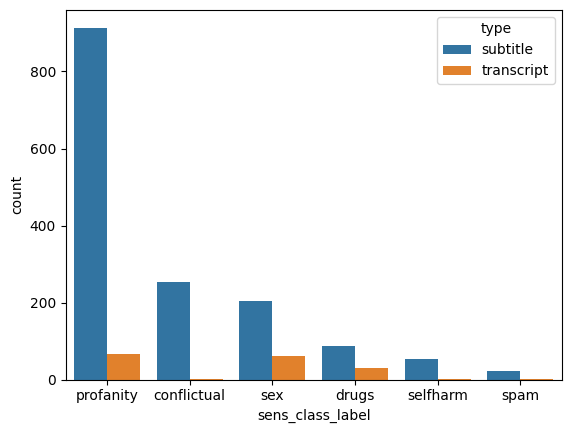

In [ ]:
full_df = pd.concat([filtered_subs_df[['sens_class_label', 'type']], red_trans_df[['sens_class_label', 'type']]])
full_df = full_df[full_df.sens_class_label.ne('not-sensitive')]
counts_df = full_df.groupby('type').sens_class_label.value_counts().reset_index()

sns.barplot(counts_df, x='sens_class_label', y='count', hue='type')

<Axes: xlabel='sens_class_label', ylabel='count'>

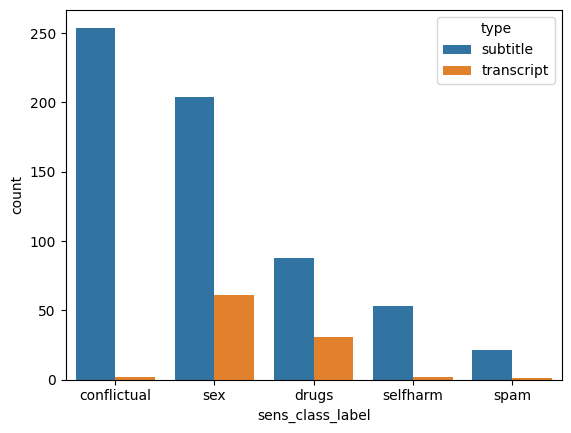

In [54]:
full_df = pd.concat([filtered_subs_df[['sens_class_label', 'type']], red_trans_df[['sens_class_label', 'type']]])
full_df = full_df[~full_df.sens_class_label.isin(['not-sensitive', 'profanity'])]
counts_df = full_df.groupby('type').sens_class_label.value_counts().reset_index()

sns.barplot(counts_df, x='sens_class_label', y='count', hue='type')

In [56]:
hate_model_name = 'GroNLP/hateBERT'
hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_name)
tokenizer = AutoTokenizer.from_pretrained(hate_model_name)
hate_model.to(device)
hate_model.eval()
clear_output()

In [60]:
from torch.utils.data import DataLoader, Dataset
class SubtitleDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]
    
    
def predict_abusive_language_batch(model, tokenizer, texts, batch_size=32):
    dataset = SubtitleDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    results = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = [str(text) for text in batch]  
            inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True).to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1)
            results.extend(probabilities.cpu().numpy())

    return results


def classify_abusive_language_batch(model, tokenizer, texts, threshold=0.5, batch_size=32):
    probabilities = predict_abusive_language_batch(model, tokenizer, texts, batch_size=batch_size)
    classifications = []
    for prob in probabilities:
        abusive_probability = prob[1]
        if abusive_probability > threshold:
            classifications.append(("Abusive Language", abusive_probability))
        else:
            classifications.append(("Non-Abusive Language", abusive_probability))
    return classifications

In [100]:
texts = red_trans_df['text'].tolist()
trans_results = classify_abusive_language_batch(hate_model, tokenizer, texts, batch_size=32)
subs_results = classify_abusive_language_batch(hate_model, tokenizer, filtered_subs_df['raw_dialogue'].tolist(), batch_size=32)

In [104]:
copy_red_trans_df = red_trans_df.copy()
copy_subs_df = filtered_subs_df.copy()

In [157]:
red_trans_df['hate_class'] = [x[0] for x in trans_results]
red_trans_df['hate_prob'] = [x[1] for x in trans_results]

filtered_subs_df['hate_class'] = [x[0] for x in subs_results]
filtered_subs_df['hate_prob'] = [x[1] for x in subs_results]

In [141]:
trans_counts_df = copy_red_trans_df.groupby('movie_name')['classification'].value_counts().reset_index().rename(columns={'movie_name': 'movie'})
trans_counts_df['type'] = 'Transcripts'
subs_counts_df = copy_subs_df.groupby('movie')['classification'].value_counts().reset_index()
subs_counts_df['type'] = 'Subtitles'

full_counts_df = pd.concat([trans_counts_df, subs_counts_df])

In [1]:
df = full_counts_df[full_counts_df.classification.eq('Abusive Language')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df[df.type.eq('Subtitles')], x='count', bins=30, ax=ax1, xlabel='Number of Abusives Instances in Film')
# plt.xlabel('Number of Abusives Instances in Film')
sns.histplot(df[df.type.eq('Transcripts')], x='count', bins=30, ax=ax2)
# plt.xlabel('Number of Abusives Instances in Film')

NameError: name 'full_counts_df' is not defined

In [162]:
filtered_subs_df[filtered_subs_df.movie.eq('Annie Hall')].sens_class_label.value_counts()

sens_class_label
not-sensitive    1490
sex                28
conflictual        15
drugs              13
profanity           8
selfharm            4
Name: count, dtype: int64

In [160]:
red_trans_df[red_trans_df.movie_name.eq('Annie Hall')].sens_class_label.value_counts()

sens_class_label
not-sensitive    208
sex                1
Name: count, dtype: int64

In [163]:
filtered_subs_df[filtered_subs_df.movie.eq('Annie Hall')].hate_class.value_counts()

hate_class
Non-Abusive Language    1543
Abusive Language          15
Name: count, dtype: int64

In [172]:
red_trans_df[red_trans_df.movie_name.eq('Annie Hall') & red_trans_df.hate_class.eq('Abusive Language')]['text'].to_list()

[' Copywrites something on a scrap of paper and hands it back.',
 ' I always felt he was essentially a technical filmmaker. And he takes out a newspaper.',
 ' on an indoor tennis court. Two women wait. Alvie and Rob join them.',
 ' putting his arm around her.']

In [175]:
red_trans_df[red_trans_df.movie_name.eq('Annie Hall') & red_trans_df.sens_class_label.ne('not-sensitive')]['text']

4091     my jaw now. Massaging himself around the mouth.
Name: text, dtype: object